In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
from keras.preprocessing import image
from imagenet_utils import preprocess_input
from scipy import misc

In [4]:
# image size
IMAGE_W = 224
IMAGE_H = 224

LEARNING_RATE = 2.0
ALPHA = 1
BETA = 10**3
# style loss wegiht
E_W = [0.2, 0.2, 0.2, 0.2, 0.2]


In [5]:
# for nerual network
def conv2d(x, W):
        return tf.nn.conv2d(x,W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


# for image process
def read_image_file(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_H,IMAGE_W))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def reverse_preprocess(x):
    x[:, :, :, 0] += 103.939
    x[:, :, :, 1] += 116.779
    x[:, :, :, 2] += 123.68    
    return x[:, :, :, ::-1]

def visualize_img(x):
    return np.clip(x, 0, 255).astype('uint8')


In [9]:
# Style Transfer Network
class STN:

    def __init__(self):
        self._build_network()
    
    def _build_network(self):
        
        vggW = np.load('vgg_weight.npy')

        W_CONV1_1 = tf.constant(vggW[0])
        b_CONV1_1 = tf.constant(vggW[1])
        W_CONV1_2 = tf.constant(vggW[2])
        b_CONV1_2 = tf.constant(vggW[3])

        W_CONV2_1 = tf.constant(vggW[4])
        b_CONV2_1 = tf.constant(vggW[5])
        W_CONV2_2 = tf.constant(vggW[6])
        b_CONV2_2 = tf.constant(vggW[7])

        W_CONV3_1 = tf.constant(vggW[8])
        b_CONV3_1 = tf.constant(vggW[9])
        W_CONV3_2 = tf.constant(vggW[10])
        b_CONV3_2 = tf.constant(vggW[11])
        W_CONV3_3 = tf.constant(vggW[12])
        b_CONV3_3 = tf.constant(vggW[13])
        W_CONV3_4 = tf.constant(vggW[14])
        b_CONV3_4 = tf.constant(vggW[15])

        W_CONV4_1 = tf.constant(vggW[16])
        b_CONV4_1 = tf.constant(vggW[17])
        W_CONV4_2 = tf.constant(vggW[18])
        b_CONV4_2 = tf.constant(vggW[19])
        W_CONV4_3 = tf.constant(vggW[20])
        b_CONV4_3 = tf.constant(vggW[21])
        W_CONV4_4 = tf.constant(vggW[22])
        b_CONV4_4 = tf.constant(vggW[23])

        W_CONV5_1 = tf.constant(vggW[24])
        b_CONV5_1 = tf.constant(vggW[25])

        self.x = tf.Variable(tf.random_uniform(shape=(1,IMAGE_H, IMAGE_W, 3), minval= 0,maxval=255))
        h_conv1_1 = tf.nn.relu(conv2d(self.x, W_CONV1_1) + b_CONV1_1)
        h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, W_CONV1_2) + b_CONV1_2)
        h_pool1 = avg_pool_2x2(h_conv1_2)

        h_conv2_1 = tf.nn.relu(conv2d(h_pool1,   W_CONV2_1) + b_CONV2_1)
        h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W_CONV2_2) + b_CONV2_2)
        h_pool2 = avg_pool_2x2(h_conv2_2)

        h_conv3_1 = tf.nn.relu(conv2d(h_pool2,   W_CONV3_1) + b_CONV3_1)
        h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, W_CONV3_2) + b_CONV3_2)
        h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, W_CONV3_3) + b_CONV3_3)
        h_conv3_4 = tf.nn.relu(conv2d(h_conv3_3, W_CONV3_4) + b_CONV3_4)
        h_pool3 = avg_pool_2x2(h_conv3_4)

        h_conv4_1 = tf.nn.relu(conv2d(h_pool3,   W_CONV4_1) + b_CONV4_1)
        h_conv4_2 = tf.nn.relu(conv2d(h_conv4_1, W_CONV4_2) + b_CONV4_2)
        h_conv4_3 = tf.nn.relu(conv2d(h_conv4_2, W_CONV4_3) + b_CONV4_3)
        h_conv4_4 = tf.nn.relu(conv2d(h_conv4_3, W_CONV4_4) + b_CONV4_4)
        h_pool4 = avg_pool_2x2(h_conv4_4)

        h_conv5_1 = tf.nn.relu(conv2d(h_pool4, W_CONV5_1) + b_CONV5_1)

        self.f1sh = tf.shape(h_conv1_1)
        self.f2sh = tf.shape(h_conv2_1)
        self.f3sh = tf.shape(h_conv3_1)
        self.f4sh = tf.shape(h_conv4_1)
        self.f5sh = tf.shape(h_conv5_1)

        F1 = tf.reshape(h_conv1_1, [self.f1sh[1]*self.f1sh[2], self.f1sh[3]])
        F2 = tf.reshape(h_conv2_1, [self.f2sh[1]*self.f2sh[2], self.f2sh[3]])
        F3 = tf.reshape(h_conv3_1, [self.f3sh[1]*self.f3sh[2], self.f3sh[3]])
        F4 = tf.reshape(h_conv4_1, [self.f4sh[1]*self.f4sh[2], self.f4sh[3]])
        F5 = tf.reshape(h_conv5_1, [self.f5sh[1]*self.f5sh[2], self.f5sh[3]])
        
        # style feature map
        self.A1 = tf.matmul(tf.transpose(F1),F1)
        self.A2 = tf.matmul(tf.transpose(F2),F2)
        self.A3 = tf.matmul(tf.transpose(F3),F3)
        self.A4 = tf.matmul(tf.transpose(F4),F4)
        self.A5 = tf.matmul(tf.transpose(F5),F5)
        
        # content feature map
        self.F42 = tf.reshape(h_conv4_2, [self.f4sh[1]*self.f4sh[2], self.f4sh[3]])
        
        # change content feature layer
#         self.F42 = tf.reshape(h_conv2_2, [self.f2sh[1]*self.f2sh[2], self.f2sh[3]])
    

    
    def set_content_feature(self, content_image):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(self.x.assign(content_image))
            self.content_fmap = sess.run([self.F42])
        
        

    def set_style_feature(self, style_image):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(self.x.assign(style_image))
            self.style_fmap = sess.run([self.A1, self.A2, self.A3, self.A4, self.A5])
    
    def _calc_loss(self):
        
        self.cont_loss = tf.reduce_sum(tf.pow(self.F42 - self.content_fmap[0], 2))/2

        E1 = tf.reduce_sum(tf.pow(self.A1 - self.style_fmap[0], 2))
        E2 = tf.reduce_sum(tf.pow(self.A2 - self.style_fmap[1], 2))
        E3 = tf.reduce_sum(tf.pow(self.A3 - self.style_fmap[2], 2))
        E4 = tf.reduce_sum(tf.pow(self.A4 - self.style_fmap[3], 2))
        E5 = tf.reduce_sum(tf.pow(self.A5 - self.style_fmap[4], 2))

        self.sty_loss =  E_W[0] * E1 /(4*((IMAGE_H)*(IMAGE_W)*64)**2) \
                        +E_W[1] * E2 /(4*((IMAGE_H/2)*(IMAGE_W/2)*128)**2) \
                        +E_W[2] * E3 /(4*((IMAGE_H/4)*(IMAGE_W/4)*256)**2) \
                        +E_W[3] * E4 /(4*((IMAGE_H/8)*(IMAGE_W/8)*512)**2) \
                        +E_W[4] * E5 /(4*((IMAGE_H/16)*(IMAGE_W/16)*512)**2)

        self.total_loss = ALPHA*self.cont_loss + BETA*self.sty_loss

    def transferring(self, iteration=500):
        self._calc_loss()
        self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.total_loss)
        inp = np.random.uniform(-20, 20 ,(1, IMAGE_H, IMAGE_W,3 )).astype('float32')
#         inp= read_image_file('content_image.jpg')
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(self.x.assign(inp))
            for i in range(iteration+1):
                if i % 400 ==0:

                    cost,cont_loss,sty_loss, mixed_image = sess.run([self.total_loss,self.cont_loss,self.sty_loss, self.x])
                    print('iteration : %d, cost : %g, cont_loss : %g, sty_loss : %g, sum : %g'%(i, cost,cont_loss,sty_loss, np.sum(mixed_image)))
                    
                    # result image save
                    mixed_image = reverse_preprocess(mixed_image)
                    mixed_image = np.squeeze(mixed_image, axis=0)
                    mixed_image = visualize_img(mixed_image)
                    plt.imshow(mixed_image)
                    plt.show()
                
                sess.run(self.optimizer)

# standard result

iteration : 0, cost : 6.63054e+11, cont_loss : 4.6029e+10, sty_loss : 6.40039e+08, sum : -5458.98


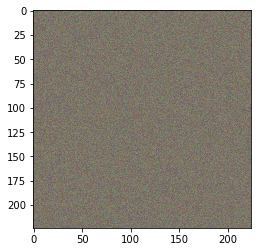

iteration : 400, cost : 2.05924e+10, cont_loss : 3.12055e+10, sty_loss : 4.98967e+06, sum : -316384


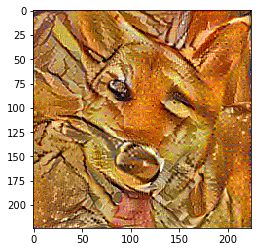

iteration : 800, cost : 1.6592e+10, cont_loss : 2.54035e+10, sty_loss : 3.89021e+06, sum : 302717


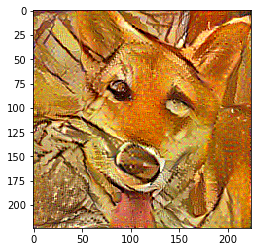

iteration : 1200, cost : 1.55781e+10, cont_loss : 2.38768e+10, sty_loss : 3.6397e+06, sum : 823844


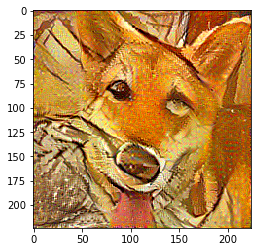

iteration : 1600, cost : 1.51241e+10, cont_loss : 2.31415e+10, sty_loss : 3.55332e+06, sum : 1.14421e+06


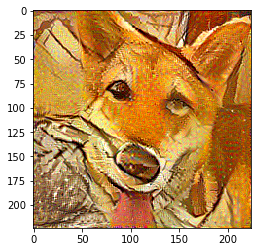

iteration : 2000, cost : 1.48372e+10, cont_loss : 2.26557e+10, sty_loss : 3.50931e+06, sum : 1.32285e+06


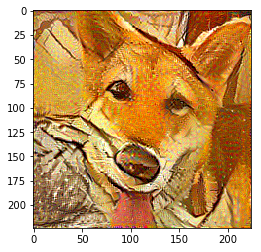

In [6]:
def standard_test():

    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)

# run
standard_test()

# max pooling 이용

iteration : 0, cost : 3.2859e+13, cont_loss : 2.43689e+11, sty_loss : 3.27371e+10, sum : -2217.35


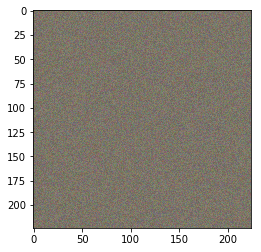

iteration : 400, cost : 3.14326e+11, cont_loss : 4.07048e+11, sty_loss : 1.10802e+08, sum : 52003.1


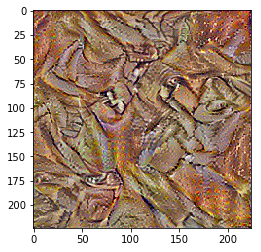

iteration : 800, cost : 2.45516e+11, cont_loss : 3.52942e+11, sty_loss : 6.90445e+07, sum : 19615.7


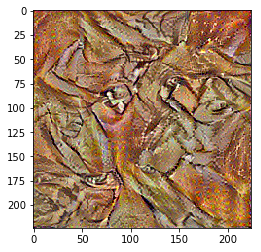

iteration : 1200, cost : 2.13543e+11, cont_loss : 3.16234e+11, sty_loss : 5.54256e+07, sum : 23965.4


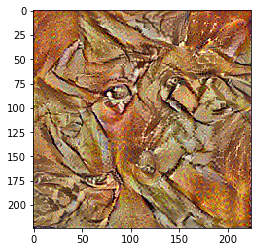

iteration : 1600, cost : 1.92224e+11, cont_loss : 2.89663e+11, sty_loss : 4.73925e+07, sum : 40973.6


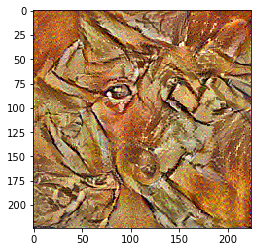

iteration : 2000, cost : 1.79374e+11, cont_loss : 2.73131e+11, sty_loss : 4.28089e+07, sum : 70657.7


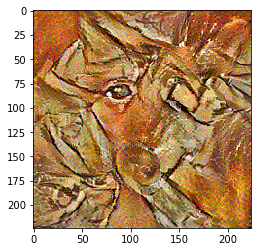

In [9]:
def pooling_change():
    # pooling change : avg --> max
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
    
#run
pooling_change()

# content layer conv4_2 에서 conv2_2이용

iteration : 0, cost : 6.74221e+11, cont_loss : 6.82642e+10, sty_loss : 6.40089e+08, sum : -7375.75


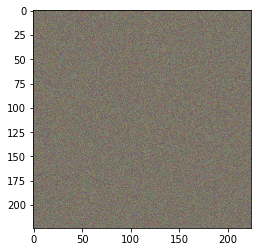

iteration : 400, cost : 2.58869e+10, cont_loss : 3.82242e+10, sty_loss : 6.77482e+06, sum : -216933


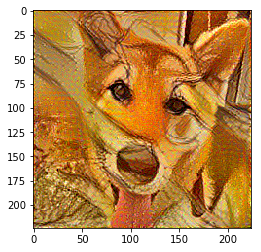

iteration : 800, cost : 1.93191e+10, cont_loss : 2.73197e+10, sty_loss : 5.65928e+06, sum : 791284


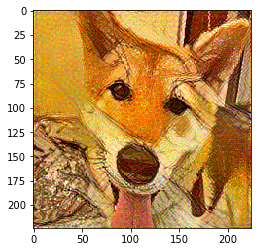

iteration : 1200, cost : 1.82496e+10, cont_loss : 2.5633e+10, sty_loss : 5.43303e+06, sum : 1.22987e+06


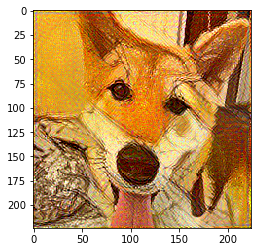

iteration : 1600, cost : 1.79061e+10, cont_loss : 2.5134e+10, sty_loss : 5.33907e+06, sum : 1.35127e+06


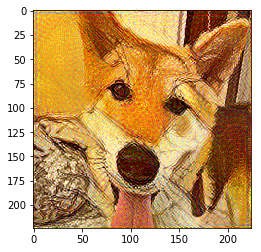

iteration : 2000, cost : 1.77739e+10, cont_loss : 2.49005e+10, sty_loss : 5.32364e+06, sum : 1.37813e+06


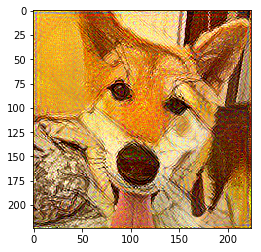

In [14]:
def content_layer_change():
    # content layer change : conv 4-2 --> conv 2-2
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
# run
content_layer_change()

# content, style loss의 weight 변경 content : style = 1:10^5

iteration : 0, cost : 6.40289e+13, cont_loss : 2.29904e+10, sty_loss : 6.40059e+08, sum : 4711.77


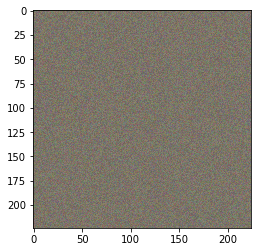

iteration : 400, cost : 2.73273e+11, cont_loss : 3.78712e+10, sty_loss : 2.35402e+06, sum : -347733


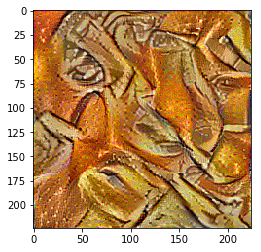

iteration : 800, cost : 1.43139e+11, cont_loss : 3.74064e+10, sty_loss : 1.05733e+06, sum : 176885


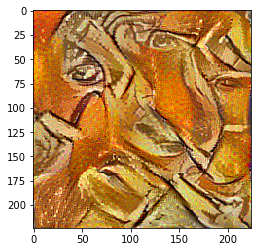

iteration : 1200, cost : 1.08981e+11, cont_loss : 3.71857e+10, sty_loss : 717949, sum : 663646


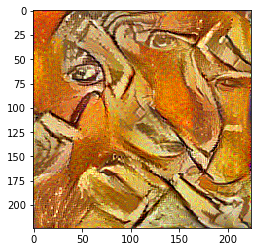

iteration : 1600, cost : 9.39387e+10, cont_loss : 3.70116e+10, sty_loss : 569272, sum : 1.03873e+06


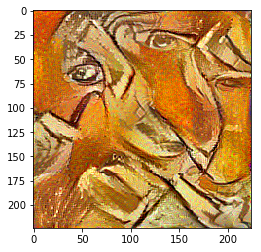

iteration : 2000, cost : 8.48407e+10, cont_loss : 3.68817e+10, sty_loss : 479590, sum : 1.30199e+06


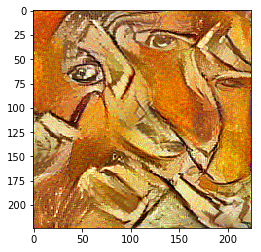

In [19]:
def change_alpha_beta():
     # change alpha 1 -->1, beta 10**3 --> 10**5
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
change_alpha_beta()

# content, style loss의 weight 변경 content : style = 1:10^4

iteration : 0, cost : 6.42059e+12, cont_loss : 2.29902e+10, sty_loss : 6.3976e+08, sum : 1572.38


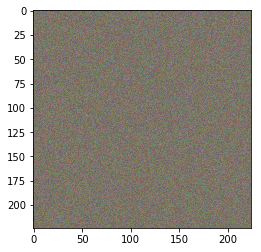

iteration : 400, cost : 6.01654e+10, cont_loss : 3.45334e+10, sty_loss : 2.5632e+06, sum : -333890


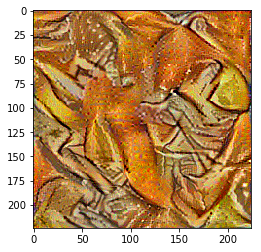

iteration : 800, cost : 4.39463e+10, cont_loss : 3.11818e+10, sty_loss : 1.27645e+06, sum : 211640


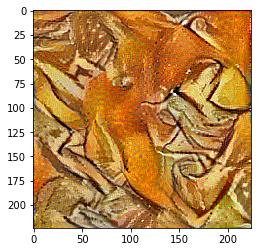

iteration : 1200, cost : 3.82479e+10, cont_loss : 2.85076e+10, sty_loss : 974025, sum : 711863


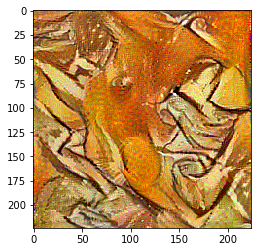

iteration : 1600, cost : 3.5258e+10, cont_loss : 2.67199e+10, sty_loss : 853810, sum : 1.09973e+06


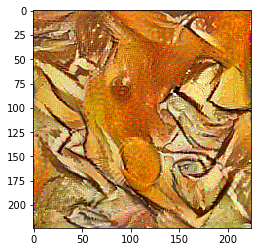

iteration : 2000, cost : 3.32284e+10, cont_loss : 2.537e+10, sty_loss : 785834, sum : 1.37583e+06


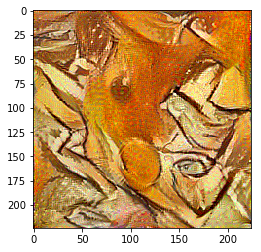

In [23]:
def change_alpha_beta2():
     # change alpha 1 -->1, beta 10**3 --> 10**4
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
change_alpha_beta2()

# content, style loss의 weight 변경 content : style = 1:10^2

iteration : 0, cost : 8.70101e+10, cont_loss : 2.3011e+10, sty_loss : 6.3999e+08, sum : 4725.53


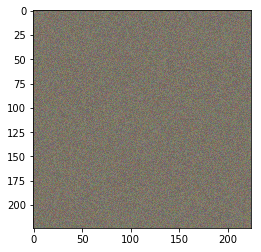

iteration : 400, cost : 8.05278e+09, cont_loss : 5.57983e+09, sty_loss : 2.47295e+07, sum : 66119.5


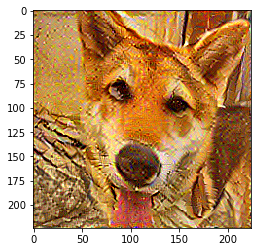

iteration : 800, cost : 7.64556e+09, cont_loss : 5.22251e+09, sty_loss : 2.42305e+07, sum : 677484


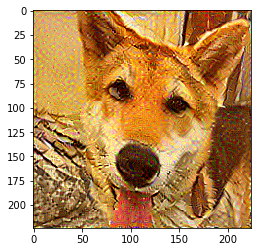

iteration : 1200, cost : 7.54567e+09, cont_loss : 5.13415e+09, sty_loss : 2.41152e+07, sum : 1.01878e+06


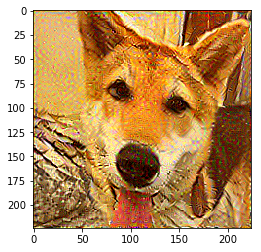

iteration : 1600, cost : 7.50034e+09, cont_loss : 5.09015e+09, sty_loss : 2.41019e+07, sum : 1.19859e+06


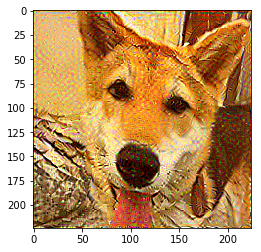

iteration : 2000, cost : 7.47692e+09, cont_loss : 5.08594e+09, sty_loss : 2.39098e+07, sum : 1.27697e+06


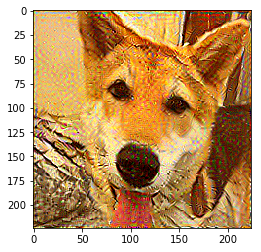

In [11]:
def change_alpha_beta3():
    # change alpha 1 -->1, beta 10**3 --> 10**2
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
change_alpha_beta3()

# 입력으로 noise image가 아닌 content image

iteration : 0, cost : 3.20947e+11, cont_loss : 0, sty_loss : 3.20947e+08, sum : 5.43067e+06


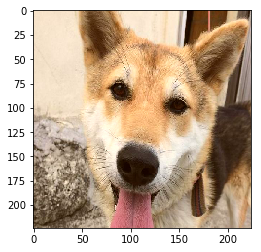

iteration : 400, cost : 1.60017e+10, cont_loss : 1.13497e+10, sty_loss : 4.65194e+06, sum : 3.97071e+06


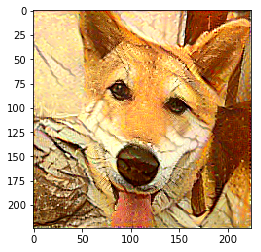

iteration : 800, cost : 1.49314e+10, cont_loss : 1.09661e+10, sty_loss : 3.96527e+06, sum : 3.05825e+06


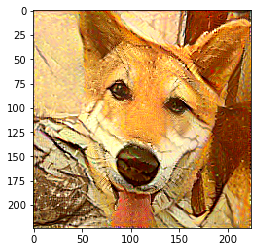

iteration : 1200, cost : 1.45626e+10, cont_loss : 1.08031e+10, sty_loss : 3.75952e+06, sum : 2.46574e+06


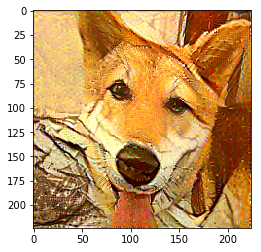

iteration : 1600, cost : 1.43931e+10, cont_loss : 1.07181e+10, sty_loss : 3.67498e+06, sum : 2.08004e+06


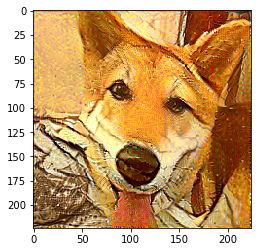

iteration : 2000, cost : 1.43057e+10, cont_loss : 1.0677e+10, sty_loss : 3.62866e+06, sum : 1.83581e+06


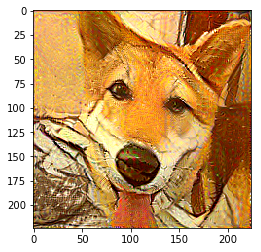

In [31]:
def change_input_image_to_content_image():
     
    m1 = STN()  
    
    # read content image and set content feature map
    content_image = read_image_file('content_image.jpg')
    m1.set_content_feature(content_image)
    
    # read style image and set style feature map
    style_image = read_image_file('style_image.jpg')
    m1.set_style_feature(style_image)
    
    # set noise image and transferring
    m1.transferring(iteration= 2000)
    
change_input_image_to_content_image()